In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
spark = SparkSession.builder.master('local[3]').getOrCreate()
sc = spark.sparkContext
spark

In [3]:
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("yellow_tripdata_2024-01.parquet")

In [4]:
df.select("*").limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [9]:
zones = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [36]:
disputes = df.filter(df.payment_type == 4).join(zones, df.PULocationID == zones.LocationID).groupBy("Borough").count()
nodisputes = df.filter(df.payment_type != 4).join(zones, df.PULocationID == zones.LocationID).groupBy("Borough").count().withColumnRenamed("count", "nocount")
combined = disputes.join(nodisputes, "Borough")
PUresult = combined.withColumn("Probability", combined["count"] / (combined["count"] + combined["nocount"]))
PUresult.toPandas()


,Borough,count,nocount,Probability
0,Queens,7307,265821,0.026753
1,EWR,15,280,0.050847
2,Unknown,107,10253,0.010328
3,Brooklyn,375,24883,0.014847
4,Staten Island,4,68,0.055556
5,N/A,88,1570,0.053076
6,Manhattan,38668,2608280,0.014609
7,Bronx,64,6841,0.009269


In [37]:
disputes = df.filter(df.payment_type == 4).join(zones, df.DOLocationID == zones.LocationID).groupBy("Borough").count()
nodisputes = df.filter(df.payment_type != 4).join(zones, df.DOLocationID == zones.LocationID).groupBy("Borough").count().withColumnRenamed("count", "nocount")
combined = disputes.join(nodisputes, "Borough")
DOresult = combined.withColumn("Probability", combined["count"] / (combined["count"] + combined["nocount"]))
DOresult.toPandas()


,Borough,count,nocount,Probability
0,Queens,5451,141536,0.037085
1,EWR,114,7062,0.015886
2,Unknown,117,15999,0.007260
3,Brooklyn,2079,105139,0.019390
4,Staten Island,33,626,0.050076
5,N/A,448,11519,0.037436
6,Manhattan,37592,2619158,0.014150
7,Bronx,794,16957,0.044730


[0.026753024223074896, 0.05084745762711865, 0.010328185328185328, 0.014846781217831975, 0.05555555555555555, 0.05307599517490953, 0.014608522721262375, 0.009268645908761766]


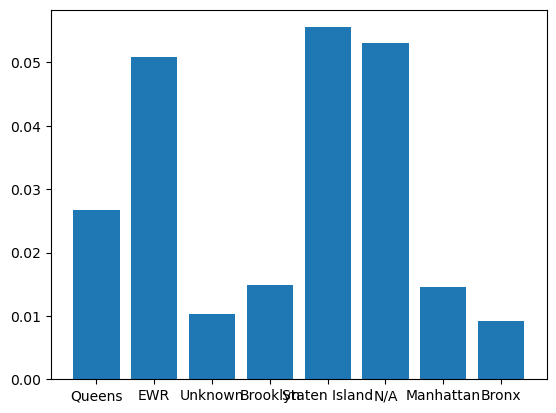

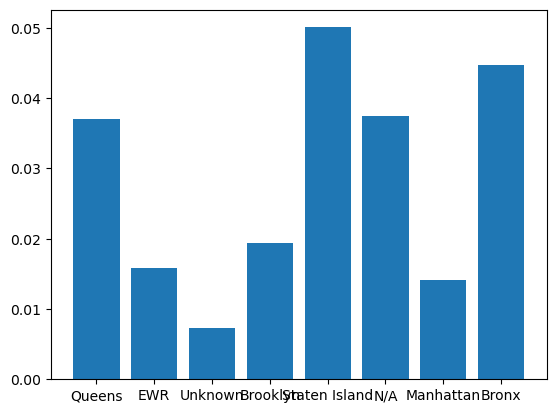

['Queens',
 'EWR',
 'Unknown',
 'Brooklyn',
 'Staten Island',
 'N/A',
 'Manhattan',
 'Bronx']

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt

PUdata = PUresult.collect()
DOdata = DOresult.collect()

x = [x["Borough"] for x in PUdata]
PUy = [y["Probability"] for y in PUdata]
DOy = [y["Probability"] for y in DOdata]
print(PUy)

plt.bar(x, PUy)
plt.plot()
plt.show()

plt.bar(x, DOy)
plt.plot()
plt.show()

"""
x1 = [x.hour for x in data]
y1 = [x["avg(speed)"] for x in data]

plt.bar(x1, y1)
plt.plot()

plt.xlabel("Hora")
plt.ylabel("Velocidad media (km/h)")
plt.title("Velocidad media por hora")
plt.show()
"""
x